In [59]:
import networkx as nx
import numpy as np
from random import random
import pandas as pd
from scipy.stats import bernoulli
import copy

In [14]:
G = nx.planted_partition_graph(3, 5, 0.7, 0.05, seed=40)

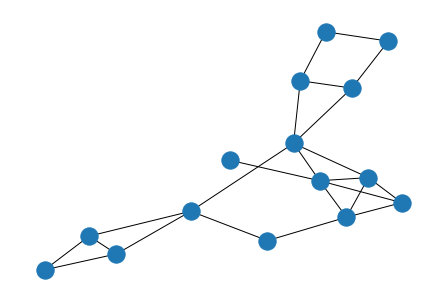

In [15]:
pos = nx.spring_layout(G)
nx.draw(G, pos = pos)

In [16]:
def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad

def train(A, Att, C, iterations = 1):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C)
    X = Att
    # weight matrix is (# of attributes, # of groups)
    W = np.random.rand(Att.shape[1], C)
    F_new = np.zeros((N,C))
    W_new = W
    alpha = 0.005
    ll = .01
    ll_new = 0
    for n in range(iterations):
        for person in range(N):
            grad = gradient(F, A, person)
            F_new[person] += 0.005*grad + F[person]
        Q = np.divide(1, 1 + np.exp(-F.dot(W.T)))
        F_new += alpha*(X-Q).dot(W_new)
        W_new += alpha*(np.dot((X-Q).T, F) - np.sign(W_new))
    
        F = np.maximum(.001, F_new) # should this be 0?
        ll_new = log_likelihood(F, A)
        ll_new += np.sum(X*np.log(Q) + (1 - X)*np.log(1 - Q))
        change = (ll - ll_new) / ll
        if abs(change) < .001:
            break
    delta = (-np.log(1- (1/N)))**.5
    return F>delta, W

In [60]:
# bigclam algorithm taken from https://github.com/RobRomijnders/bigclam
def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad

def train(A, Att, C, iterations = 100):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C)
    X = Att
    W = np.random.rand(Att.shape[1], C)
    F_new = np.zeros((N,C))
    ll = .01
    ll_new = 0
    for n in range(iterations):
        for person in range(N):
            grad = gradient(F, A, person)
            F_new[person] += 0.005*grad + F[person]
            F_new[person] = np.maximum(0.001, F_new[person])
        Q = np.divide(1, 1 + np.exp(-F.dot(W.T)))
        F_new += 0.005*((X-Q).dot(W))
        W += 0.005*((X-Q).T.dot(F))
        F = np.maximum(.001, F_new)
        ll_new = log_likelihood(F, A)
        ll_new += np.sum(X*np.log(Q) + (1 - X)*np.log(1 - Q))
        change = (ll - ll_new) / ll
        if abs(change) < .001:
            break
    delta = (-np.log(1- (1/N)))**.5
    
    return F>delta, W

In [182]:
# bigclam algorithm taken from https://github.com/RobRomijnders/bigclam
def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad

def train(A, Att, C, iterations = 100, alpha = .005, lambda_W = .001):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C)
    F_new = np.zeros((N,C))
    X = Att
    W = np.random.rand(Att.shape[1], C)
    W_new = np.zeros((Att.shape[1], C))
    ll = .01
    ll_new = 0
    Q = np.zeros((F.shape[0], W.shape[0]))
    Sanity = np.zeros((F.shape[0], W.shape[0]))
    for n in range(iterations):
        for u in range(Q.shape[0]):
            for k in range(Q.shape[1]):
                running_sum = 0
                for c in range(F.shape[1]):
                    running_sum += W[k][c] * F[u][c]
                    
                Q[u][k] = 1/(1+np.exp(-running_sum))
        
        for u in range(X.shape[0]):
            grad = gradient(F, A, u)
            for c in range(F.shape[1]):
                running_sum = 0
                for k in range(X.shape[1]):
                    running_sum += (X[u][k] - Q[u][k]) * W[k][c]
                F_new[u][c] = max(.001, F[u][c] + alpha*(running_sum + grad[c]))
        
        for k in range(X.shape[1]):
            for c in range(F.shape[1]):
                running_sum = 0
                for u in range(F.shape[0]):
                    running_sum += (X[u][k] - Q[u][k]) * F[u][c]
                W_new[k][c] = W[k][c] + alpha * running_sum - alpha * lambda_W * np.sign(W[k][c])
        
         
        F = copy.deepcopy(F_new)
        W = copy.deepcopy(W_new)
        ll_new = log_likelihood(F, A)
        ll_new += np.sum(X*np.log(Q) + (1 - X)*np.log(1 - Q))
        change = (ll - ll_new) / ll
        if abs(change) < .001:
            break
        else:
            ll = ll_new
    delta = (-np.log(1 - (1/N)))**.5
    
    return F > delta, W

In [19]:
attr_mat = np.array([np.random.rand(3) for node in G.nodes()])

In [20]:
r = bernoulli.rvs(attr_mat)

In [21]:
A = nx.to_numpy_array(G)

In [183]:
F, W = train(A, r, 3, 400)

In [184]:
W

array([[ 0.38828343, -0.14773731,  0.84552916],
       [ 0.02547343,  0.2242985 ,  0.38686888],
       [ 0.46386904,  0.04744827, -0.27769976]])

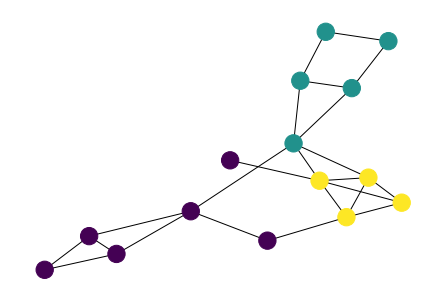

In [187]:
nx.draw(G, pos = pos, node_color=np.argmax(F,1))

In [10]:
r = bernoulli.rvs(attr_mat)

In [11]:
X = r

In [12]:
F = np.random.rand(A.shape[0],3)

In [16]:
np.zeros((A.shape[0], 1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [12]:
W = np.random.rand(attr_mat.shape[1], 3)
Q = np.divide(1, 1 + np.exp(-F.dot(W.T)))

In [17]:
(X-Q).T.dot(F)

array([[-2.19066251, -1.94284167, -1.11451379],
       [-1.19420239, -1.69822925, -1.599987  ],
       [-3.81706255, -2.54273981, -2.20906011]])

In [27]:
X-Q

array([[-0.55850864, -0.61368096, -0.55836144],
       [-0.64975145, -0.64498793, -0.58872347],
       [-0.65142885,  0.28187628,  0.37936559],
       [-0.74542044,  0.25916467, -0.62237092],
       [-0.73197842, -0.71508777, -0.61297821],
       [-0.75126923,  0.34009435,  0.40238946],
       [-0.60098235,  0.38119355, -0.54740357],
       [-0.63047518,  0.26803926,  0.3970152 ],
       [ 0.26115435,  0.37195998,  0.40685031],
       [ 0.39692511, -0.59153684,  0.44784879],
       [-0.81999754, -0.78589288, -0.6592967 ],
       [ 0.39459824, -0.65119123, -0.57079829],
       [ 0.37136248,  0.22377726,  0.38191158],
       [-0.75368404,  0.32791117, -0.59898318],
       [ 0.22368198, -0.69318924, -0.59798952]])

In [28]:
W

array([[0.02901613, 0.78977294, 0.78560341],
       [0.86624472, 0.05766854, 0.74593758],
       [0.35336792, 0.20381885, 0.25900221]])

In [32]:
F

array([[0.49923474, 0.25877888, 0.02068375],
       [0.55986629, 0.66339788, 0.09899142],
       [0.93791131, 0.64313949, 0.11478707],
       [0.51933717, 0.58555979, 0.75967921],
       [0.47724546, 0.62695346, 0.63096065],
       [0.22770602, 0.83452632, 0.55969662],
       [0.17200186, 0.07028383, 0.44432192],
       [0.73071288, 0.16689824, 0.48528522],
       [0.26162027, 0.98676967, 0.32212468],
       [0.2675659 , 0.36296898, 0.15767109],
       [0.62352041, 0.95686458, 0.9451753 ],
       [0.45842873, 0.2406932 , 0.28593226],
       [0.89770195, 0.01286795, 0.62393517],
       [0.22032232, 0.76423716, 0.64713493],
       [0.06100946, 0.60327744, 0.97519239]])

In [34]:
(X-Q)[:,0].dot(F)

array([-2.70007323, -3.38850791, -2.72565162])

In [70]:
np.sum((X-Q)*F, axis = 1)

array([-0.4491836 , -0.84993613, -0.38615046, -0.70817038, -1.18442525,
        0.33796518, -0.31980174, -0.22329545,  0.56641862, -0.03789309,
       -1.88642922, -0.13905177,  0.57454044, -0.30307445, -0.98769355])

In [78]:
(X-Q).T.dot(F)

array([[-2.70007323, -3.38850791, -2.72565162],
       [-0.88958168, -1.26773618, -1.03531966],
       [-0.85282935, -1.69404368, -2.02837146]])

In [32]:
np.sum(X*np.log(Q) + (1 - X)*np.log(1 - Q))

-38.24745321273891

In [31]:
F

array([[0.83188316, 0.57099882, 0.41335032],
       [0.1502041 , 0.86585031, 0.64456369],
       [0.92239563, 0.53780645, 0.03032487],
       [0.83070944, 0.0716564 , 0.42437599],
       [0.91794534, 0.28133656, 0.28655788],
       [0.58697926, 0.91375061, 0.67562283],
       [0.86896529, 0.56967386, 0.85949531],
       [0.36106567, 0.55469333, 0.12737662],
       [0.2854244 , 0.27583251, 0.4269491 ],
       [0.25438008, 0.71919536, 0.53314427],
       [0.45380408, 0.43140985, 0.12989525],
       [0.91663695, 0.0710327 , 0.40273391],
       [0.57918898, 0.98063066, 0.67037769],
       [0.29397678, 0.38383733, 0.26593979],
       [0.09159491, 0.919213  , 0.28693405]])

In [178]:
def bigclam(A, X, K, alpha):
    """
    BigCLAM algorithm for community detection with node features and prior.
    A: adjacency matrix of the graph
    X: node feature matrix
    K: number of communities
    alpha: parameter for the prior probability
    """
    N = A.shape[0] # number of nodes
    F = X.shape[1] # number of features

    # initialize community assignments and feature matrices
    c = np.random.randint(0, K, N)
    mu = np.random.rand(K, F)
    sigma = np.random.rand(K, F)
    count = 0
    max_iter = 100
    # E-step
    while True:
        # compute the prior probability
        prior = np.zeros((N, K))
        for k in range(K):
            mask = (c == k)
            prior[:, k] = np.sum(A[:, mask], axis=1) * alpha
        # compute the likelihood
        likelihood = np.zeros((N, K))
        for k in range(K):
            likelihood[:, k] = multivariate_normal.pdf(X, mean=mu[k], cov=sigma[k])
        # compute the total probability
        probability = likelihood * prior
        probability /= np.sum(probability, axis=1, keepdims=True)

        # check for convergence
        new_c = np.argmax(probability, axis=1)
        if np.array_equal(new_c, c):
            break
        c = new_c
        if count == max_iter:
            break
        count +=1
    return c

In [8]:
attr_mat = np.array([np.random.rand(3) for node in G.nodes()])

In [176]:
pred = bigclam(A, attr_mat, 3, .05)

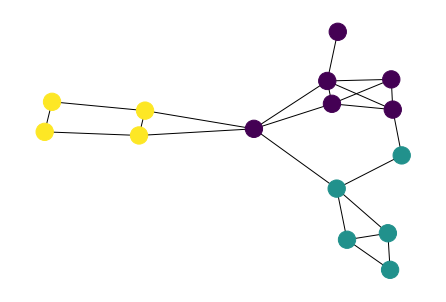

In [177]:
pos = nx.spring_layout(G)
nx.draw(G, pos = pos, node_color=pred)